# Import dependencies

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import math
from scipy.optimize import curve_fit


%matplotlib inline

# Functions

In [3]:
def fit_data(totale_casi, func):
    xdata = np.arange(len(totale_casi))
    popt, pcov = curve_fit(func, xdata, totale_casi)
    
    print("Parameters: {0}".format(popt))
    
    plt.rcParams.update({"legend.fontsize": "x-large",
                     "figure.figsize": (20, 15),
                     'xtick.labelsize': 10})
    ax = plt.gca()
    formatter = mdates.DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)

    plt.plot(data, totale_casi, label="Totale casi")
    plt.plot(data, func(xdata, *popt), "--", label="Curve fit")

    plt.legend(loc="upper left")
    plt.show()
    
    return xdata, popt, pcov

# Load data

In [4]:
dati_andamento_nazionale_fpath = "../../dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(dati_andamento_nazionale_fpath, sep=",")

In [5]:
df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
29,2020-03-24T17:00:00,ITA,21937,3396,25333,28697,54030,3612,8326,6820,69176,296964,NaN,NaN
30,2020-03-25T17:00:00,ITA,23112,3489,26601,30920,57521,3491,9362,7503,74386,324445,NaN,NaN
31,2020-03-26T17:00:00,ITA,24753,3612,28365,33648,62013,4492,10361,8165,80539,361060,pd-IT-0007,pd-EN-0007
32,2020-03-27T17:00:00,ITA,26029,3732,29761,36653,66414,4401,10950,9134,86498,394079,NaN,NaN
33,2020-03-28T17:00:00,ITA,26676,3856,30532,39533,70065,3651,12384,10023,92472,429526,NaN,NaN


## Coverti data: string to datetime object

In [6]:
df.loc[:, "data"] = df.loc[:, "data"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S"))

In [7]:
df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
29,2020-03-24 17:00:00,ITA,21937,3396,25333,28697,54030,3612,8326,6820,69176,296964,NaN,NaN
30,2020-03-25 17:00:00,ITA,23112,3489,26601,30920,57521,3491,9362,7503,74386,324445,NaN,NaN
31,2020-03-26 17:00:00,ITA,24753,3612,28365,33648,62013,4492,10361,8165,80539,361060,pd-IT-0007,pd-EN-0007
32,2020-03-27 17:00:00,ITA,26029,3732,29761,36653,66414,4401,10950,9134,86498,394079,NaN,NaN
33,2020-03-28 17:00:00,ITA,26676,3856,30532,39533,70065,3651,12384,10023,92472,429526,NaN,NaN


# Totale casi 

In [8]:
df[ df["data"] == df["data"].max() ]

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
33,2020-03-28 17:00:00,ITA,26676,3856,30532,39533,70065,3651,12384,10023,92472,429526,NaN,NaN


In [9]:
df[ df["data"] == df["data"].max() ][["totale_casi"]]

,totale_casi
33,92472


## Grafico andamento giornaliero

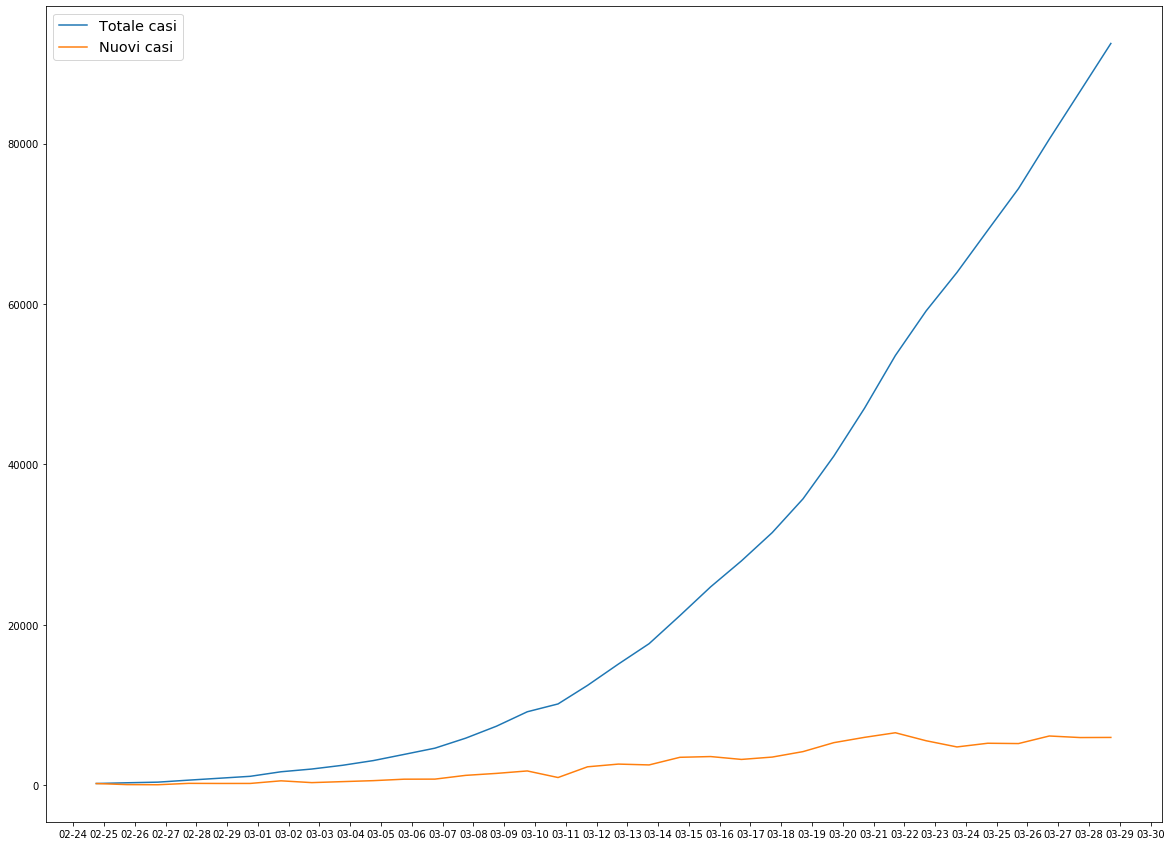

In [10]:
plt.rcParams.update({"legend.fontsize": "x-large",
                     "figure.figsize": (20, 15),
                     'xtick.labelsize': 10})
ax = plt.gca()
formatter = mdates.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.DayLocator()
ax.xaxis.set_major_locator(locator)

data = df["data"].values
totale_casi = df["totale_casi"].values
nuovi_casi = np.roll(totale_casi, 1)
nuovi_casi[0] = 0

plt.plot(data, totale_casi, label="Totale casi")
plt.plot(data, totale_casi - nuovi_casi, label="Nuovi casi")

plt.legend(loc="upper left")
plt.show()

# Exponential curve fit per casi totali

In [11]:
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

Parameters: [ 6.20407526e+03  8.63041168e-02 -9.34289860e+03]


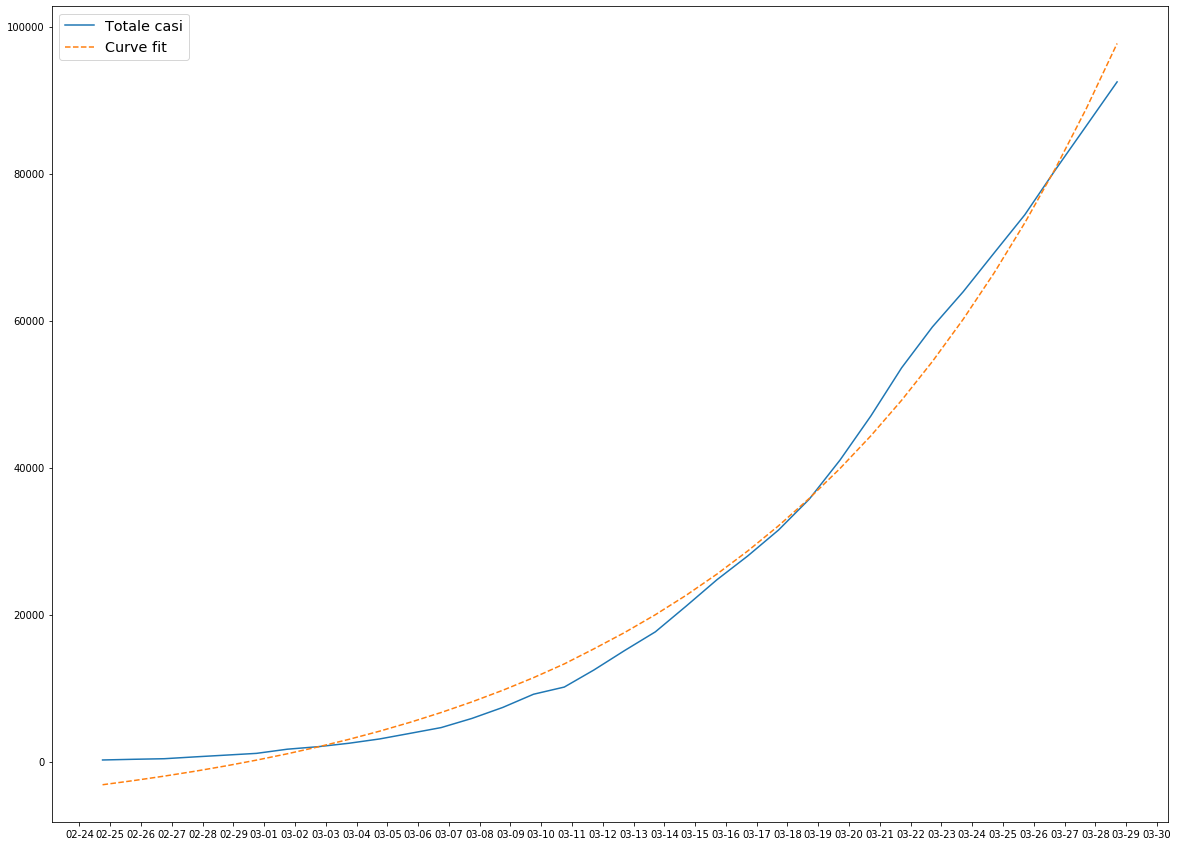

In [12]:
xdata, popt_exp, pcov_exp = fit_data(totale_casi, exponential_func)

In [13]:
np.sqrt(np.diag(pcov_exp)).sum()

2545.352525288607

In [14]:
exponential_pred = exponential_func(np.array([xdata[-1]+1]), *popt_exp).astype(int)
print(exponential_pred)

[107350]


# Cubic curve fit per casi totali

In [15]:
def cubic_func(x, a, b, c, d):
    return a*np.power(x, 3) + b*np.power(x, 2) + c*x + d

Parameters: [ 1.03651864e+00  7.13327492e+01 -6.58939712e+02  1.70123469e+03]


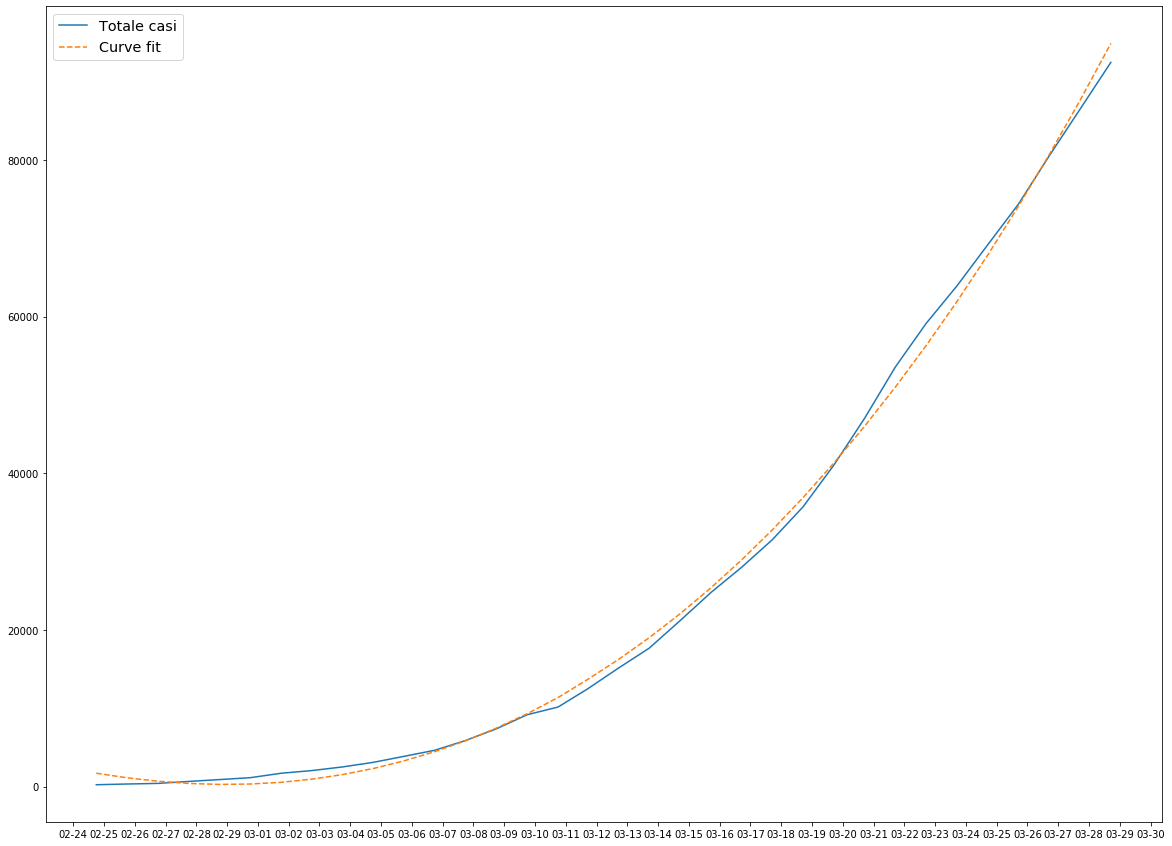

In [16]:
xdata, popt_cub, pcov_cub = fit_data(totale_casi, cubic_func)

## Errore parametri

In [17]:
np.sqrt(np.diag(pcov_cub)).sum()

1002.8885094731962

## Predizione giorno seguente

In [18]:
cubic_pred = cubic_func(np.array([xdata[-1]+1]), *popt_cub).astype(int)
print(cubic_pred)

[102497]


# Quadratic curve fit per casi totali

In [19]:
def quadratic_func(x, a, b, c):
    return a*np.power(x, 2) + b*x + c

Parameters: [  122.64042217 -1326.14676663  3397.80843527]


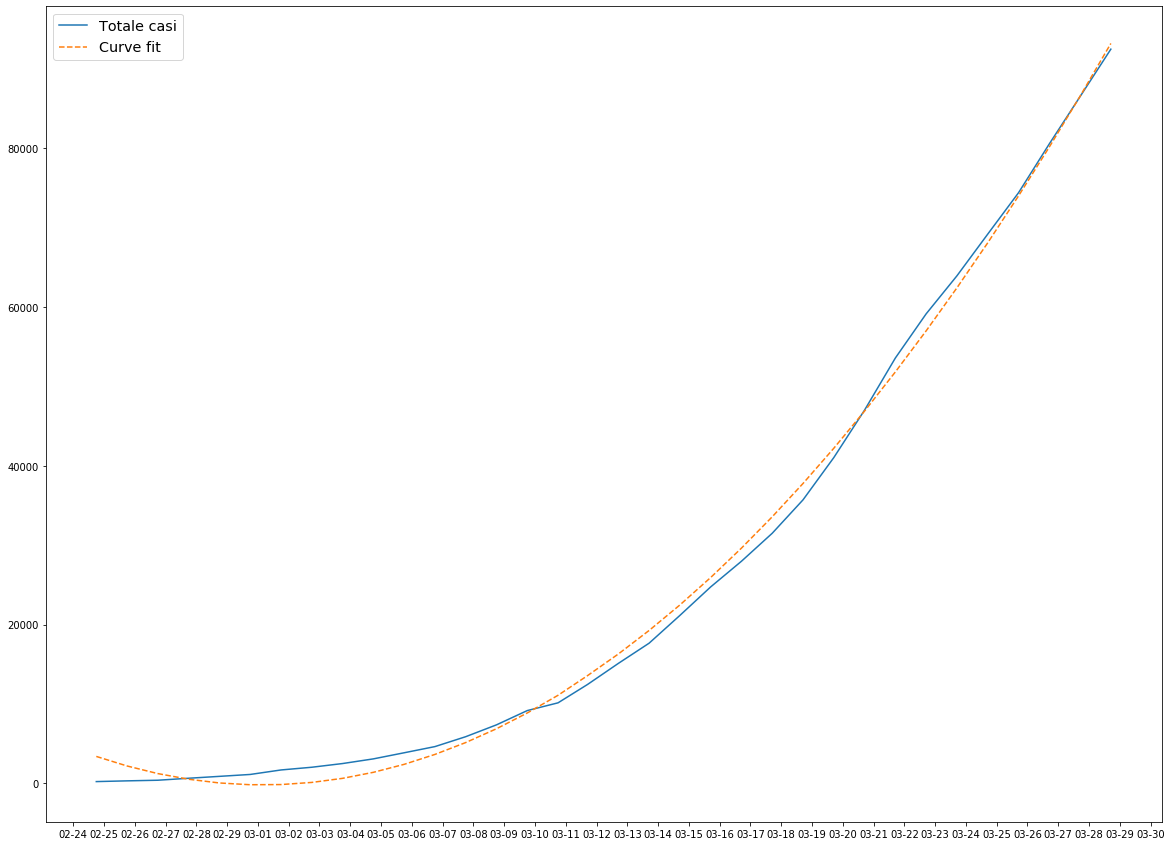

In [20]:
xdata, popt_sqr, pcov_sqr = fit_data(totale_casi, quadratic_func)

## Errore parametri

In [21]:
np.sqrt(np.diag(pcov_sqr)).sum()

822.4521992980225

## Predizione giorno seguente

In [22]:
quadratic_pred = quadratic_func(np.array([xdata[-1]+1]), *popt_sqr).astype(int)
print(quadratic_pred)

[100081]


# Combinazione modelli

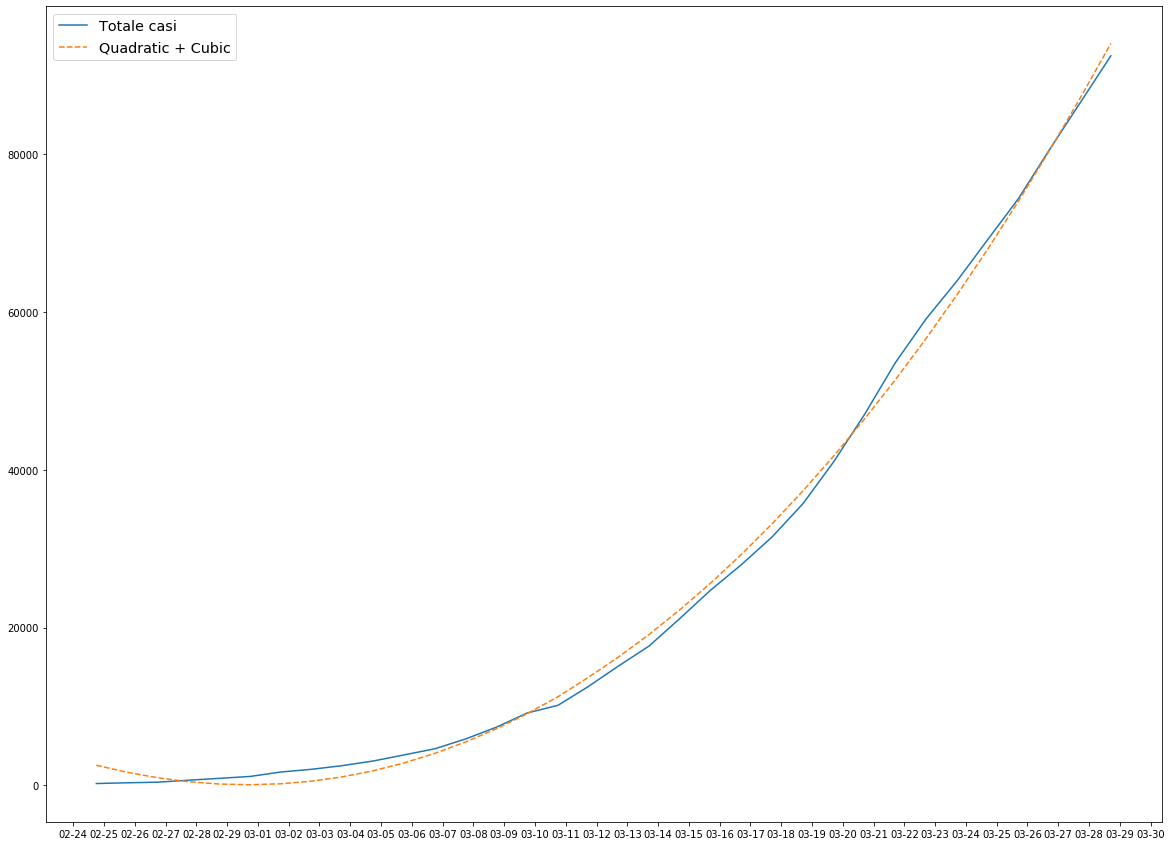

In [23]:
ensemble = (quadratic_func(xdata, *popt_sqr) + cubic_func(xdata, *popt_cub))/2

plt.rcParams.update({"legend.fontsize": "x-large",
                 "figure.figsize": (20, 15),
                 'xtick.labelsize': 10})
ax = plt.gca()
formatter = mdates.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.DayLocator()
ax.xaxis.set_major_locator(locator)

plt.plot(data, totale_casi, label="Totale casi")
plt.plot(data, ensemble, "--", label="Quadratic + Cubic")

plt.legend(loc="upper left")
plt.show()

## Predizione giorno seguente

In [24]:
int((quadratic_pred + cubic_pred)/2)

101289

# Proiezione al 60%

In [25]:
p = 60 * 10 ** 6 * 60 / 100
a = popt_sqr[0]
b = popt_sqr[1]
c = popt_sqr[0] - p
x = int((-b + math.sqrt(b ** 2 - 4 * a * c)) / (2 * a))

Con questo ritmo di crescita saranno necessari i seguenti giorni affinchè il 60% 
della popolazione italiana contragga il virus

In [26]:
print("%d giorni" % x)

547 giorni
